
Branin:

GP EI: zero versus exact partial-order GP EI derivatives wrt **x1**, **x2**

In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=e3433e7aead919c73281bee27688d79bd79c9d6bfd8987a0bd9a23dd892f2d34
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
n_start_AcqFunc = 100 #multi-start iterations to avoid local optima in AcqFunc optimization


In [4]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util_grad_zero = 'dEI_GP'
util_grad_exact = 'dEI_GP'

n_init = 5 # random initialisations
iters = 20
opt = True

In [5]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(-dKstar, self.alpha)
        ds = -2 * np.dot(-dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO_zero:

zero_grad = 0

class dGPGO_zero(GPGO):  
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * zero_grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        exact_grad = (-f_h - f)/eps
        return exact_grad


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        exact_grad = (-f_h - f)/eps
        return exact_grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_exact = time.time()
start_exact


1629284899.3475592

In [13]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [10. 15.]. 	  -145.87219087939556 	 -5.089934878453152
3      	 [7.89233981 8.37774826]. 	  -57.131706721493586 	 -5.089934878453152
4      	 [-4.02890025 14.87019763]. 	  -4.066623147608248 	 -4.066623147608248
5      	 [3.04012742 0.5978989 ]. 	  -3.5362887887138523 	 -3.5362887887138523
6      	 [ 4.44913092 15.        ]. 	  -190.3953679346135 	 -3.5362887887138523
7      	 [4.73772708 4.55848917]. 	  -20.477725446029027 	 -3.5362887887138523
8      	 [

In [14]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [10.         14.04305153]. 	  -123.82683657114976 	 -6.692051508754487
2      	 [9.06869679 2.0164014 ]. 	  -1.0307174678975652 	 -1.0307174678975652
3      	 [-0.16427306 14.97419295]. 	  -95.32402138742069 	 -1.0307174678975652
4      	 [9.1218473  7.52213687]. 	  -28.8277818749712 	 -1.0307174678975652
5      	 [ 4.93365968 11.54871316]. 	  -117.30104137650083 	 -1.0307174678975652
6      	 [-4.64031377  1.17767303]. 	  -233.9871201335698 	 -1.0307174678975652
7      	 [-4.72522351  6.10902515]. 	  -116.12672070287879 	 -1.030717467

In [15]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-4.80375785 13.29726611]. 	  -21.95985477078912 	 -18.07886746449891
3      	 [2.48207828 1.0517852 ]. 	  -5.629026203897858 	 -5.629026203897858
4      	 [ 0.14844583 15.        ]. 	  -104.75240974675043 	 -5.629026203897858
5      	 [10.          8.34422751]. 	  -30.472315562750353 	 -5.629026203897858
6      	 [8.07001468 0.08627427]. 	  -10.141183023936915 	 -5.629026203897858
7      	 [2.60292614 5.46656783]. 	  -9.23236149779591 	 -5.629026203897858

In [16]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 0.5775056  14.31328634]. 	  -102.48870217898984 	 -7.247126865776948
2      	 [-0.13367617  0.17881992]. 	  -55.952651178085794 	 -7.247126865776948
3      	 [3.72690551 9.1691185 ]. 	  -55.378612699060426 	 -7.247126865776948
4      	 [ 6.1778888 15.       ]. 	  -212.8122931696868 	 -7.247126865776948
5      	 [-4.10209196 14.15027049]. 	  -4.801871416019723 	 -4.801871416019723
6      	 [-4.04591226  3.00759296]. 	  -137.38197722313902 	 -4.801871416019723
7      	 [-4.95336009  9.46492024]. 	  -69.87288098121975 	 -4.801871416019723

In [17]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [10. 15.]. 	  -145.87219087939556 	 -5.96108856337545
3      	 [-4.81236982  8.00518018]. 	  -85.70683082507513 	 -5.96108856337545
4      	 [ 3.68731448 15.        ]. 	  -173.72008619074884 	 -5.96108856337545
5      	 [4.3540436  1.43302077]. 	  -6.639752470693001 	 -5.96108856337545
6      	 [10.         4.3384186]. 	  -3.726599414432032 	 -3.726599414432032
7      	 [10.         10.34364558]. 	  -55.82885532794446 	 -3.726599414432032
8      	 [-4.980

In [18]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [10. 15.]. 	  -145.87219087939556 	 -15.31731051317483
2      	 [-4.42013634  0.37777   ]. 	  -237.69785665817545 	 -15.31731051317483
3      	 [ 3.61480227 14.3758058 ]. 	  -156.22942206205929 	 -15.31731051317483
4      	 [1.3323845  0.68571175]. 	  -23.985019929250733 	 -15.31731051317483
5      	 [-4.19302139 14.61872658]. 	  -5.3403971656550695 	 -5.3403971656550695
6      	 [7.50770981 9.99300926]. 	  -88.26011125495025 	 -5.3403971656550695
7      	 [-1.62279135  4.70426902]. 	  -27.298264298415273 	 -5.3403971656550695
8      	 [

In [19]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [ 6.7899837 15.       ]. 	  -210.23670723548415 	 -5.211335324193094
2      	 [-4.2086631   0.70519748]. 	  -209.3213266373998 	 -5.211335324193094
3      	 [9.84403446 2.23618575]. 	  -1.607946967220208 	 -1.607946967220208
4      	 [4.48885083 5.9470923 ]. 	  -28.01605577580937 	 -1.607946967220208
5      	 [-0.88725868 15.        ]. 	  -72.10710205884752 	 -1.607946967220208
6      	 [6.534031   0.76323316]. 	  -19.42611832770012 	 -1.607946967220208
7      	 [-4.45991373  5.69427892]. 	  -107.07170905154733 	 -1.607946967220208
8 

In [20]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [-4.98884166 14.83408411]. 	  -18.008434758014253 	 -15.416245468470875
2      	 [6.2584639  0.79690936]. 	  -19.69061392229066 	 -15.416245468470875
3      	 [-4.8401206   6.42823123]. 	  -117.34273274148853 	 -15.416245468470875
4      	 [ 0.69118494 13.24534138]. 	  -86.01770116734858 	 -15.416245468470875
5      	 [10.          3.47248178]. 	  -2.163594551564506 	 -2.163594551564506
6      	 [-3.05480493 10.66174686]. 	  -2.4098912383372877 	 -2.163594551564506
7      	 [ 4.75801559 11.11496847]. 	  -105.7544124498669 	 -2.1635

In [21]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [9.79053515 5.9968998 ]. 	  -11.24805159216164 	 -3.4640248583909496
3      	 [-0.91490984 13.25685032]. 	  -48.26155495184477 	 -3.4640248583909496
4      	 [4.42329559 9.16761691]. 	  -66.24415745540334 	 -3.4640248583909496
5      	 [8.09381179 0.36546333]. 	  -9.19702700265266 	 -3.4640248583909496
6      	 [10.         10.54747823]. 	  -58.86294724173256 	 -3.4640248583909496
7      	 [-0.15122021  8.58270778]. 	  -24.963824819197978 	 -3.4640248

In [22]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [10. 15.]. 	  -145.87219087939556 	 -2.710610964564512
2      	 [6.8990985  6.18414116]. 	  -42.99322961219224 	 -2.710610964564512
3      	 [-4.79812162  7.64003087]. 	  -91.2920569402186 	 -2.710610964564512
4      	 [ 0.92619985 15.        ]. 	  -123.16709352285076 	 -2.710610964564512
5      	 [10.          9.87183942]. 	  -49.124691842924676 	 -2.710610964564512
6      	 [1.23584501 7.41268003]. 	  -23.28336405677546 	 -2.710610964564512
7      	 [7.30917046 4.63031131]. 	  -26.277167965113733 	 -2.710610964564512
8      	 [10.  

In [23]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [7.47489909 1.17569712]. 	  -13.574666531193973 	 -13.574666531193973
2      	 [-3.32392335 14.51197433]. 	  -3.777267680584016 	 -3.777267680584016
3      	 [9.72363233 6.87677997]. 	  -17.947808548975658 	 -3.777267680584016
4      	 [2.9061772  2.49504109]. 	  -0.6635953583088394 	 -0.6635953583088394
5      	 [ 4.54037068 15.        ]. 	  -192.31380837056446 	 -0.6635953583088394
6      	 [5.47231439 6.47301576]. 	  -44.85196943993592 	 -0.6635953583088394
7      	 [-2.29503709 11.11000261]. 	  -4.241527284569879 	 -0.6635953583

In [24]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [10.          4.42297562]. 	  -3.959594663321786 	 -0.5499315281120278
2      	 [10. 15.]. 	  -145.87219087939556 	 -0.5499315281120278
3      	 [-4.02857478  0.48179288]. 	  -200.67574083550102 	 -0.5499315281120278
4      	 [ 2.85664154 13.8594499 ]. 	  -129.64706087217854 	 -0.5499315281120278
5      	 [2.71945565 1.80665114]. 	  -1.9141508093386541 	 -0.5499315281120278
6      	 [7.9150393  9.35287884]. 	  -71.145332562649 	 -0.5499315281120278
7      	 [3.48353776 6.64911516]. 	  -22.350716524246597 	 -0.5499315281120278
8 

In [25]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-3.51870171  3.68338658]. 	  -91.63196166423945 	 -18.038943061558626
2      	 [-4.35385058 13.32256485]. 	  -10.85616402870354 	 -10.85616402870354
3      	 [-0.73927277  8.63772348]. 	  -19.029143764958548 	 -10.85616402870354
4      	 [2.09747614 1.08873887]. 	  -9.758765290841207 	 -9.758765290841207
5      	 [ 0.16976309 15.        ]. 	  -105.33142284405855 	 -9.758765290841207
6      	 [2.61007618 5.69875103]. 	  -10.559825534649086 	 -9.758765290841207
7      	 [10.         10.78923428]. 	  -62.569260685577824 	 -9.75876

In [26]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-3.9690762   0.55943317]. 	  -193.7395503314444 	 -1.4149920024014744
2      	 [10. 15.]. 	  -145.87219087939556 	 -1.4149920024014744
3      	 [-3.66670736  8.25640817]. 	  -29.95349403696578 	 -1.4149920024014744
4      	 [9.39091674 7.13516668]. 	  -22.386185498178882 	 -1.4149920024014744
5      	 [ 7.25108949 11.10492442]. 	  -112.52804163360832 	 -1.4149920024014744
6      	 [-4.74819159 13.78438333]. 	  -17.553495258306747 	 -1.4149920024014744
7      	 [1.01745542 0.33800448]. 	  -32.488528858603104 	 -1.4149920024014744
8 

In [27]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [10.         13.52961303]. 	  -112.75363605665893 	 -12.768724532005583
2      	 [-3.60562328 14.8673558 ]. 	  -3.5139061901593145 	 -3.5139061901593145
3      	 [ 2.33128509 14.15725801]. 	  -128.05010787219163 	 -3.5139061901593145
4      	 [6.19145623 8.0351404 ]. 	  -67.68334148789066 	 -3.5139061901593145
5      	 [1.48208079 0.384964  ]. 	  -23.382291002085054 	 -3.5139061901593145
6      	 [10.          6.01629092]. 	  -11.023324355358392 	 -3.5139061901593145
7      	 [-4.29675819 10.25288707]. 	  -30.83021813713061 	 

In [28]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [9.91844219 8.81695252]. 	  -36.28422213736768 	 -2.715864006988424
3      	 [3.90820632 8.01405849]. 	  -42.28391486640599 	 -2.715864006988424
4      	 [9.78036449 0.12564739]. 	  -8.104164369970292 	 -2.715864006988424
5      	 [-4.32356001  1.77408484]. 	  -189.20272661085582 	 -2.715864006988424
6      	 [ 0.45618055 13.20713457]. 	  -81.12955981694466 	 -2.715864006988424
7      	 [10.          4.28901566]. 	  -3.597088562611952 	 -2.715864006988424
8 

In [29]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [9.76575296 0.98553483]. 	  -4.1623278326263815 	 -4.1623278326263815
2      	 [-4.0692092  14.64043819]. 	  -4.241825729253317 	 -4.1623278326263815
3      	 [10. 15.]. 	  -145.87219087939556 	 -4.1623278326263815
4      	 [ 3.03819562 14.9592515 ]. 	  -159.26550321070087 	 -4.1623278326263815
5      	 [3.8618099  0.73368105]. 	  -3.8779506963621575 	 -3.8779506963621575
6      	 [10.          5.66490873]. 	  -9.029129800364839 	 -3.8779506963621575
7      	 [6.18301175 3.93663313]. 	  -27.611202129846948 	 -3.8779506963621575
8

In [30]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-1.88826854  6.70399181]. 	  -14.630614325969386 	 -8.150075223157177
3      	 [-0.6538924 15.       ]. 	  -80.09560277106152 	 -8.150075223157177
4      	 [3.55188376 2.40649444]. 	  -1.3794738071685266 	 -1.3794738071685266
5      	 [ 0.97448377 10.61102989]. 	  -51.86556046457193 	 -1.3794738071685266
6      	 [10.          6.76728284]. 	  -16.11329263377079 	 -1.3794738071685266
7      	 [10. 15.]. 	  -145.87219087939556 	 -1.3794738071685266
8      	

In [31]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [8.6773951  0.80876842]. 	  -4.184707152540867 	 -4.184707152540867
2      	 [4.45041553 5.47999855]. 	  -23.54840201771013 	 -4.184707152540867
3      	 [ 0.08624589 15.        ]. 	  -103.03846780814712 	 -4.184707152540867
4      	 [10. 15.]. 	  -145.87219087939556 	 -4.184707152540867
5      	 [-0.91513787  7.50858772]. 	  -15.857374423419069 	 -4.184707152540867
6      	 [10.          4.77778615]. 	  -5.093160567527242 	 -4.184707152540867
7      	 [4.76905454 0.49670355]. 	  -11.268474335538237 	 -4.184707152540867
8      	 [-4.

In [32]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-4.88337277  1.15554411]. 	  -258.03874991509736 	 -14.042667401507376
2      	 [10.        5.847943]. 	  -10.037088221310093 	 -10.037088221310093
3      	 [9.98998478 0.35020336]. 	  -8.875777366291523 	 -8.875777366291523
4      	 [-1.71590052 15.        ]. 	  -43.28836110402055 	 -8.875777366291523
5      	 [0.11401177 1.25905543]. 	  -40.344030206075885 	 -8.875777366291523
6      	 [5.81288806 8.34803223]. 	  -70.8966132322713 	 -8.875777366291523
7      	 [-0.09617023 11.409629  ]. 	  -47.176704813052176 	 -8.87577736629

In [33]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

start_zero = time.time()
start_zero

1629288180.4616632

In [34]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_zero_1 = dGaussianProcess(cov_func, optimize=opt)

zero_1 = dGPGO_zero(surrogate_zero_1, Acquisition_new(util_grad_zero), objfunc, param)
zero_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [9.62110556 9.549066  ]. 	  -48.240386346213874 	 -5.089934878453152
3      	 [-3.40124185 14.78563236]. 	  -4.246346957669259 	 -4.246346957669259
4      	 [ 5.75393503 14.80989262]. 	  -205.71967217110094 	 -4.246346957669259
5      	 [3.04012742 0.5978989 ]. 	  -3.5362887887138523 	 -3.5362887887138523
6      	 [4.57532981 4.91354166]. 	  -20.87585798447303 	 -3.5362887887138523
7      	 [ 5.44405125 10.17723681]. 	  -97.64909642372251 	 -3.536288788713

In [35]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_zero_2 = dGaussianProcess(cov_func, optimize=opt)

zero_2 = dGPGO_zero(surrogate_zero_2, Acquisition_new(util_grad_zero), objfunc, param)
zero_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [ 8.8924193 14.1167381]. 	  -147.03001228842345 	 -6.692051508754487
2      	 [9.06869679 2.0164014 ]. 	  -1.0307174678975652 	 -1.0307174678975652
3      	 [-0.16427306 14.97419295]. 	  -95.32402138742069 	 -1.0307174678975652
4      	 [9.1218473  7.52213687]. 	  -28.8277818749712 	 -1.0307174678975652
5      	 [-4.18406245  1.39245696]. 	  -188.1729109967922 	 -1.0307174678975652
6      	 [ 5.63078896 10.12483776]. 	  -98.46139675860731 	 -1.0307174678975652
7      	 [-4.8352934   5.99895526]. 	  -126.03115617782663 	 -1.030717467897

In [36]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_zero_3 = dGaussianProcess(cov_func, optimize=opt)

zero_3 = dGPGO_zero(surrogate_zero_3, Acquisition_new(util_grad_zero), objfunc, param)
zero_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-4.80375785 13.29726611]. 	  -21.95985477078912 	 -18.07886746449891
3      	 [2.48207828 1.0517852 ]. 	  -5.629026204992 	 -5.629026204992
4      	 [8.98585605 0.28386512]. 	  -4.7149819787426 	 -4.7149819787426
5      	 [ 0.41580135 14.46980621]. 	  -101.76219452971873 	 -4.7149819787426
6      	 [9.76070045 7.97000832]. 	  -27.944148501372332 	 -4.7149819787426
7      	 [1.37673158 4.47788607]. 	  -12.031675104602485 	 -4.7149819787426
8      	 [ 4.511

In [37]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_zero_4 = dGaussianProcess(cov_func, optimize=opt)

zero_4 = dGPGO_zero(surrogate_zero_4, Acquisition_new(util_grad_zero), objfunc, param)
zero_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 0.5775056  14.31328634]. 	  -102.48870217898984 	 -7.247126865776948
2      	 [-0.13367617  0.17881992]. 	  -55.952651178085794 	 -7.247126865776948
3      	 [-4.98639995 14.6489551 ]. 	  -18.844355450809267 	 -7.247126865776948
4      	 [4.32819126 9.17004107]. 	  -64.74807516948553 	 -7.247126865776948
5      	 [ 6.33722481 13.96549562]. 	  -185.05510990689925 	 -7.247126865776948
6      	 [-4.04591226  3.00759296]. 	  -137.3819772231602 	 -7.247126865776948
7      	 [-4.95336009  9.46492024]. 	  -69.87288098121975 	 -7.2471268657769

In [38]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_zero_5 = dGaussianProcess(cov_func, optimize=opt)

zero_5 = dGPGO_zero(surrogate_zero_5, Acquisition_new(util_grad_zero), objfunc, param)
zero_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [ 9.0736314  14.50090003]. 	  -152.42565438241107 	 -5.96108856337545
3      	 [-4.81236982  8.00518018]. 	  -85.70683082507513 	 -5.96108856337545
4      	 [4.92771672 2.72360202]. 	  -14.094838740236458 	 -5.96108856337545
5      	 [ 2.62045273 13.79918705]. 	  -124.49848586716293 	 -5.96108856337545
6      	 [9.71341146 4.22996994]. 	  -3.0473090259367748 	 -3.0473090259367748
7      	 [9.77913062 9.81004798]. 	  -50.273770834770254 	 -3.04730902593677

In [39]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_zero_6 = dGaussianProcess(cov_func, optimize=opt)

zero_6 = dGPGO_zero(surrogate_zero_6, Acquisition_new(util_grad_zero), objfunc, param)
zero_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [ 9.72522083 14.5299912 ]. 	  -139.8297584868663 	 -15.31731051317483
2      	 [-4.42013634  0.37777   ]. 	  -237.69785665817545 	 -15.31731051317483
3      	 [ 3.61480227 14.3758058 ]. 	  -156.22942206205929 	 -15.31731051317483
4      	 [1.33236176 0.68568901]. 	  -23.985581932967577 	 -15.31731051317483
5      	 [-4.19302139 14.61872658]. 	  -5.3403971656550695 	 -5.3403971656550695
6      	 [6.93979299 8.86576579]. 	  -76.72885006129056 	 -5.3403971656550695
7      	 [-0.62756227  4.02959083]. 	  -26.89343882344727 	 -5.3403971656550

In [40]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_zero_7 = dGaussianProcess(cov_func, optimize=opt)

zero_7 = dGPGO_zero(surrogate_zero_7, Acquisition_new(util_grad_zero), objfunc, param)
zero_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [-4.97859679  1.38393519]. 	  -260.3293952774437 	 -5.211335324193094
2      	 [ 9.25668108 14.87713055]. 	  -157.79168966390583 	 -5.211335324193094
3      	 [9.84403446 2.23618575]. 	  -1.607946967220208 	 -1.607946967220208
4      	 [4.4556015  6.00369035]. 	  -28.08564757730271 	 -1.607946967220208
5      	 [6.35373325 2.29835966]. 	  -21.00737877973323 	 -1.607946967220208
6      	 [-0.66517009 14.88752362]. 	  -77.9546048777314 	 -1.607946967220208
7      	 [ 5.54463207 12.59528833]. 	  -148.1645262404861 	 -1.607946967220208
8 

In [41]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_zero_8 = dGaussianProcess(cov_func, optimize=opt)

zero_8 = dGPGO_zero(surrogate_zero_8, Acquisition_new(util_grad_zero), objfunc, param)
zero_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [-4.98884166 14.83408411]. 	  -18.008434758014253 	 -15.416245468470875
2      	 [6.2584639  0.79690936]. 	  -19.69061392229066 	 -15.416245468470875
3      	 [-4.8401206   6.42823123]. 	  -117.34273274148853 	 -15.416245468470875
4      	 [ 0.69118494 13.24534138]. 	  -86.01770116734858 	 -15.416245468470875
5      	 [9.94893905 2.63385163]. 	  -1.7886495956543573 	 -1.7886495956543573
6      	 [ 4.7257508  11.35808086]. 	  -110.01443632013836 	 -1.7886495956543573
7      	 [-3.41443607 11.12963977]. 	  -4.031664421256778 	 -1.788

In [42]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_zero_9 = dGaussianProcess(cov_func, optimize=opt)

zero_9 = dGPGO_zero(surrogate_zero_9, Acquisition_new(util_grad_zero), objfunc, param)
zero_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [9.79053515 5.9968998 ]. 	  -11.24805159216164 	 -3.4640248583909496
3      	 [-0.91490984 13.25685032]. 	  -48.26155495184477 	 -3.4640248583909496
4      	 [4.42329559 9.16761691]. 	  -66.24415745540334 	 -3.4640248583909496
5      	 [8.09381179 0.36546333]. 	  -9.19702700265266 	 -3.4640248583909496
6      	 [9.02009592 9.88176431]. 	  -60.87947560531562 	 -3.4640248583909496
7      	 [-0.39567811  8.64756316]. 	  -22.85060157590238 	 -3.4640248583

In [43]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_zero_10 = dGaussianProcess(cov_func, optimize=opt)

zero_10 = dGPGO_zero(surrogate_zero_10, Acquisition_new(util_grad_zero), objfunc, param)
zero_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [8.70372597 6.86774268]. 	  -27.130126017218842 	 -2.710610964564512
2      	 [ 9.45036259 14.63089076]. 	  -147.64044674485945 	 -2.710610964564512
3      	 [-4.79812162  7.64003087]. 	  -91.29205695323067 	 -2.710610964564512
4      	 [ 1.08105942 14.97116497]. 	  -125.62413988622455 	 -2.710610964564512
5      	 [0.51015743 8.64425952]. 	  -30.09349758524735 	 -2.710610964564512
6      	 [2.19204141 0.07879985]. 	  -13.733110847097937 	 -2.710610964564512
7      	 [-4.31113374 14.62074842]. 	  -6.661365851958085 	 -2.71061096456451

In [44]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_zero_11 = dGaussianProcess(cov_func, optimize=opt)

zero_11 = dGPGO_zero(surrogate_zero_11, Acquisition_new(util_grad_zero), objfunc, param)
zero_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [7.47489909 1.17569712]. 	  -13.574666531193973 	 -13.574666531193973
2      	 [-3.32392335 14.51197433]. 	  -3.777267680584016 	 -3.777267680584016
3      	 [9.72363233 6.87677997]. 	  -17.947808548975658 	 -3.777267680584016
4      	 [2.9061772  2.49504109]. 	  -0.6635953583088394 	 -0.6635953583088394
5      	 [ 3.58353585 14.94720983]. 	  -170.10293330444745 	 -0.6635953583088394
6      	 [5.84362524 7.9475965 ]. 	  -65.42880822655968 	 -0.6635953583088394
7      	 [-4.24195362 11.18444573]. 	  -20.790611799545804 	 -0.663595358

In [45]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_zero_12 = dGaussianProcess(cov_func, optimize=opt)

zero_12 = dGPGO_zero(surrogate_zero_12, Acquisition_new(util_grad_zero), objfunc, param)
zero_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [9.82941798 5.1689241 ]. 	  -6.608972192182115 	 -0.5499315281120278
2      	 [ 8.68497867 14.25940608]. 	  -155.1276557842789 	 -0.5499315281120278
3      	 [-4.02857478  0.48179288]. 	  -200.67574083550102 	 -0.5499315281120278
4      	 [2.78415581 0.5847599 ]. 	  -4.946964199486606 	 -0.5499315281120278
5      	 [ 2.33380414 14.34125566]. 	  -132.23186597332315 	 -0.5499315281120278
6      	 [5.62360485 9.20963842]. 	  -82.78452011516237 	 -0.5499315281120278
7      	 [5.30315919 3.63571485]. 	  -21.315826037119237 	 -0.54993

In [46]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_zero_13 = dGaussianProcess(cov_func, optimize=opt)

zero_13 = dGPGO_zero(surrogate_zero_13, Acquisition_new(util_grad_zero), objfunc, param)
zero_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-3.51870171  3.68338658]. 	  -91.63196166423945 	 -18.038943061558626
2      	 [-4.35385058 13.32256485]. 	  -10.85616402870354 	 -10.85616402870354
3      	 [1.92708537 6.15494401]. 	  -14.170722295282301 	 -10.85616402870354
4      	 [2.09747614 1.08873887]. 	  -9.758765291026968 	 -9.758765291026968
5      	 [-2.20936067  9.03510658]. 	  -5.51279147987421 	 -5.51279147987421
6      	 [-1.08240402 12.34082106]. 	  -34.45740312765656 	 -5.51279147987421
7      	 [9.58257282 1.44180739]. 	  -1.884941566191383 	 -1.8849415661913

In [47]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_zero_14 = dGaussianProcess(cov_func, optimize=opt)

zero_14 = dGPGO_zero(surrogate_zero_14, Acquisition_new(util_grad_zero), objfunc, param)
zero_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-3.9690762   0.55943317]. 	  -193.7395503314444 	 -1.4149920024014744
2      	 [9.91083167 7.9391897 ]. 	  -26.74726853005628 	 -1.4149920024014744
3      	 [-3.66670736  8.25640817]. 	  -29.95349403696578 	 -1.4149920024014744
4      	 [ 9.14372498 14.98887041]. 	  -163.10109673985522 	 -1.4149920024014744
5      	 [6.65832741 5.3299567 ]. 	  -36.57295497759185 	 -1.4149920024014744
6      	 [-4.74819159 13.78438333]. 	  -17.553495258306747 	 -1.4149920024014744
7      	 [0.84986577 0.17041483]. 	  -37.22573426162719 	 -1.41499200

In [48]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_zero_15 = dGaussianProcess(cov_func, optimize=opt)

zero_15 = dGPGO_zero(surrogate_zero_15, Acquisition_new(util_grad_zero), objfunc, param)
zero_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [ 6.44369262 14.11318321]. 	  -188.60210814630312 	 -12.768724532005583
2      	 [-3.60562328 14.8673558 ]. 	  -3.5139061901593145 	 -3.5139061901593145
3      	 [5.1163375  8.27183398]. 	  -63.23844101819753 	 -3.5139061901593145
4      	 [2.52736972 0.09793134]. 	  -9.468962809148586 	 -3.5139061901593145
5      	 [ 0.68465807 13.62359762]. 	  -92.30750326748647 	 -3.5139061901593145
6      	 [9.23194413 9.98766654]. 	  -59.41277313242077 	 -3.5139061901593145
7      	 [-4.44280278 10.10684248]. 	  -37.846903819649214 	 -3.5

In [49]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_zero_16 = dGaussianProcess(cov_func, optimize=opt)

zero_16 = dGPGO_zero(surrogate_zero_16, Acquisition_new(util_grad_zero), objfunc, param)
zero_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [9.91844219 8.81695252]. 	  -36.28422213736768 	 -2.715864006988424
3      	 [-4.62755895  1.21779395]. 	  -231.601623929818 	 -2.715864006988424
4      	 [3.85654417 9.13706995]. 	  -56.82460928884615 	 -2.715864006988424
5      	 [9.99139112 1.55175532]. 	  -3.9797647677453547 	 -2.715864006988424
6      	 [ 0.81269563 12.80751757]. 	  -80.8523517531238 	 -2.715864006988424
7      	 [-4.97073382 10.81852038]. 	  -51.94890158324454 	 -2.715864006988424
8   

In [50]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_zero_17 = dGaussianProcess(cov_func, optimize=opt)

zero_17 = dGPGO_zero(surrogate_zero_17, Acquisition_new(util_grad_zero), objfunc, param)
zero_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [9.76575296 0.98553483]. 	  -4.1623278326263815 	 -4.1623278326263815
2      	 [-4.0692092  14.64043819]. 	  -4.241825729253317 	 -4.1623278326263815
3      	 [ 3.50955031 14.46798657]. 	  -156.35330190687876 	 -4.1623278326263815
4      	 [ 9.71402677 14.78561227]. 	  -146.1394874425749 	 -4.1623278326263815
5      	 [3.8618099  0.73368105]. 	  -3.8779506963621575 	 -3.8779506963621575
6      	 [6.53305714 4.19509777]. 	  -28.78463404063376 	 -3.8779506963621575
7      	 [-4.2626215  11.09775992]. 	  -22.096060946627023 	 -3.877

In [51]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_zero_18 = dGaussianProcess(cov_func, optimize=opt)

zero_18 = dGPGO_zero(surrogate_zero_18, Acquisition_new(util_grad_zero), objfunc, param)
zero_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-1.88826854  6.70399181]. 	  -14.630614325969386 	 -8.150075223157177
3      	 [-0.51657686 14.28710066]. 	  -73.5610643915935 	 -8.150075223157177
4      	 [4.18472296 0.83236175]. 	  -5.757617883721708 	 -5.757617883721708
5      	 [ 0.86842496 10.0227023 ]. 	  -44.37192956087362 	 -5.757617883721708
6      	 [1.85591156 4.15882827]. 	  -7.744974706381685 	 -5.757617883721708
7      	 [-4.57265481  2.89070629]. 	  -179.95943619058488 	 -5.75761788372170

In [52]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_zero_19 = dGaussianProcess(cov_func, optimize=opt)

zero_19 = dGPGO_zero(surrogate_zero_19, Acquisition_new(util_grad_zero), objfunc, param)
zero_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [8.6773951  0.80876842]. 	  -4.184707152540867 	 -4.184707152540867
2      	 [4.45041553 5.47999855]. 	  -23.54840201771013 	 -4.184707152540867
3      	 [-4.04838436  6.32106816]. 	  -71.9700715917133 	 -4.184707152540867
4      	 [-8.69860031e-04  1.42821549e+01]. 	  -88.17326654597659 	 -4.184707152540867
5      	 [0.80655347 8.67861441]. 	  -31.685363189083702 	 -4.184707152540867
6      	 [ 8.84730394 14.24459984]. 	  -151.12771810684433 	 -4.184707152540867
7      	 [4.76905454 0.49670355]. 	  -11.268474335538237 	 -4.184707152

In [53]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_zero_20 = dGaussianProcess(cov_func, optimize=opt)

zero_20 = dGPGO_zero(surrogate_zero_20, Acquisition_new(util_grad_zero), objfunc, param)
zero_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-4.88337277  1.15554411]. 	  -258.03874991509736 	 -14.042667401507376
2      	 [-1.84310627 14.89552828]. 	  -37.92416090431381 	 -14.042667401507376
3      	 [9.98998478 0.35020336]. 	  -8.875777366291523 	 -8.875777366291523
4      	 [9.82049302 5.23462252]. 	  -6.926835976089437 	 -6.926835976089437
5      	 [0.11401177 1.25905543]. 	  -40.34403021450308 	 -6.926835976089437
6      	 [6.34167483 7.90009461]. 	  -65.79565375919643 	 -6.926835976089437
7      	 [-2.61261369  6.61203864]. 	  -21.316101052288694 	 -6.9268359760

In [54]:
end_zero = time.time()
end_zero

time_zero = end_zero - start_zero
time_zero

180.1151638031006

In [55]:
### Simple regret minimization: run number = 1

exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 
zero_output_1 = np.append(np.min(zero_1.GP.y[0:n_init]),zero_1.GP.y[n_init:(n_init+iters)]) 

regret_exact_1 = np.log(-exact_output_1 + y_global_orig)
regret_zero_1 = np.log(-zero_output_1 + y_global_orig)

simple_regret_exact_1 = min_max_array(regret_exact_1)
simple_regret_zero_1 = min_max_array(regret_zero_1)

min_simple_regret_exact_1 = min(simple_regret_exact_1)
min_simple_regret_zero_1 = min(simple_regret_zero_1)

min_simple_regret_exact_1, min_simple_regret_zero_1

(0.6645865935346397, 1.0755061841728013)

In [56]:
### Simple regret minimization: run number = 2

exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 
zero_output_2 = np.append(np.min(zero_2.GP.y[0:n_init]),zero_2.GP.y[n_init:(n_init+iters)]) 

regret_exact_2 = np.log(-exact_output_2 + y_global_orig)
regret_zero_2 = np.log(-zero_output_2 + y_global_orig)

simple_regret_exact_2 = min_max_array(regret_exact_2)
simple_regret_zero_2 = min_max_array(regret_zero_2)

min_simple_regret_exact_2 = min(simple_regret_exact_2)
min_simple_regret_zero_2 = min(simple_regret_zero_2)

min_simple_regret_exact_2, min_simple_regret_zero_2

(-0.45755271593560126, -0.45755271593560126)

In [57]:
### Simple regret minimization: run number = 3

exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 
zero_output_3 = np.append(np.min(zero_3.GP.y[0:n_init]),zero_3.GP.y[n_init:(n_init+iters)]) 

regret_exact_3 = np.log(-exact_output_3 + y_global_orig)
regret_zero_3 = np.log(-zero_output_3 + y_global_orig)

simple_regret_exact_3 = min_max_array(regret_exact_3)
simple_regret_zero_3 = min_max_array(regret_zero_3)

min_simple_regret_exact_3 = min(simple_regret_exact_3)
min_simple_regret_zero_3 = min(simple_regret_zero_3)

min_simple_regret_exact_3, min_simple_regret_zero_3

(0.4373812555756854, 0.30359376876897426)

In [58]:
### Simple regret minimization: run number = 4

exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 
zero_output_4 = np.append(np.min(zero_4.GP.y[0:n_init]),zero_4.GP.y[n_init:(n_init+iters)]) 

regret_exact_4 = np.log(-exact_output_4 + y_global_orig)
regret_zero_4 = np.log(-zero_output_4 + y_global_orig)

simple_regret_exact_4 = min_max_array(regret_exact_4)
simple_regret_zero_4 = min_max_array(regret_zero_4)

min_simple_regret_exact_4 = min(simple_regret_exact_4)
min_simple_regret_zero_4 = min(simple_regret_zero_4)

min_simple_regret_exact_4, min_simple_regret_zero_4

(0.9128468108863439, -0.029980791108480058)

In [59]:
### Simple regret minimization: run number = 5

exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 
zero_output_5 = np.append(np.min(zero_5.GP.y[0:n_init]),zero_5.GP.y[n_init:(n_init+iters)]) 

regret_exact_5 = np.log(-exact_output_5 + y_global_orig)
regret_zero_5 = np.log(-zero_output_5 + y_global_orig)

simple_regret_exact_5 = min_max_array(regret_exact_5)
simple_regret_zero_5 = min_max_array(regret_zero_5)

min_simple_regret_exact_5 = min(simple_regret_exact_5)
min_simple_regret_zero_5 = min(simple_regret_zero_5)

min_simple_regret_exact_5, min_simple_regret_zero_5

(0.6367343536969241, 0.5522698135370556)

In [60]:
### Simple regret minimization: run number = 6

exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 
zero_output_6 = np.append(np.min(zero_6.GP.y[0:n_init]),zero_6.GP.y[n_init:(n_init+iters)]) 

regret_exact_6 = np.log(-exact_output_6 + y_global_orig)
regret_zero_6 = np.log(-zero_output_6 + y_global_orig)

simple_regret_exact_6 = min_max_array(regret_exact_6)
simple_regret_zero_6 = min_max_array(regret_zero_6)

min_simple_regret_exact_6 = min(simple_regret_exact_6)
min_simple_regret_zero_6 = min(simple_regret_zero_6)

min_simple_regret_exact_6, min_simple_regret_zero_6

(-0.022727286452021003, -1.4254655049645975)

In [61]:
### Simple regret minimization: run number = 7

exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 
zero_output_7 = np.append(np.min(zero_7.GP.y[0:n_init]),zero_7.GP.y[n_init:(n_init+iters)]) 

regret_exact_7 = np.log(-exact_output_7 + y_global_orig)
regret_zero_7 = np.log(-zero_output_7 + y_global_orig)

simple_regret_exact_7 = min_max_array(regret_exact_7)
simple_regret_zero_7 = min_max_array(regret_zero_7)

min_simple_regret_exact_7 = min(simple_regret_exact_7)
min_simple_regret_zero_7 = min(simple_regret_zero_7)

min_simple_regret_exact_7, min_simple_regret_zero_7

(0.19066991806673148, -0.32354731725893604)

In [62]:
### Simple regret minimization: run number = 8

exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 
zero_output_8 = np.append(np.min(zero_8.GP.y[0:n_init]),zero_8.GP.y[n_init:(n_init+iters)]) 

regret_exact_8 = np.log(-exact_output_8 + y_global_orig)
regret_zero_8 = np.log(-zero_output_8 + y_global_orig)

simple_regret_exact_8 = min_max_array(regret_exact_8)
simple_regret_zero_8 = min_max_array(regret_zero_8)

min_simple_regret_exact_8 = min(simple_regret_exact_8)
min_simple_regret_zero_8 = min(simple_regret_zero_8)

min_simple_regret_exact_8, min_simple_regret_zero_8

(0.5685514891280867, -1.4651698406635372)

In [63]:
### Simple regret minimization: run number = 9

exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 
zero_output_9 = np.append(np.min(zero_9.GP.y[0:n_init]),zero_9.GP.y[n_init:(n_init+iters)]) 

regret_exact_9 = np.log(-exact_output_9 + y_global_orig)
regret_zero_9 = np.log(-zero_output_9 + y_global_orig)

simple_regret_exact_9 = min_max_array(regret_exact_9)
simple_regret_zero_9 = min_max_array(regret_zero_9)

min_simple_regret_exact_9 = min(simple_regret_exact_9)
min_simple_regret_zero_9 = min(simple_regret_zero_9)

min_simple_regret_exact_9, min_simple_regret_zero_9

(0.46504941214871776, 0.6686963610276819)

In [64]:
### Simple regret minimization: run number = 10

exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 
zero_output_10 = np.append(np.min(zero_10.GP.y[0:n_init]),zero_10.GP.y[n_init:(n_init+iters)]) 

regret_exact_10 = np.log(-exact_output_10 + y_global_orig)
regret_zero_10 = np.log(-zero_output_10 + y_global_orig)

simple_regret_exact_10 = min_max_array(regret_exact_10)
simple_regret_zero_10 = min_max_array(regret_zero_10)

min_simple_regret_exact_10 = min(simple_regret_exact_10)
min_simple_regret_zero_10 = min(simple_regret_zero_10)

min_simple_regret_exact_10, min_simple_regret_zero_10

(1.0999810345784744, -5.437914608852267)

In [65]:
### Simple regret minimization: run number = 11

exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 
zero_output_11 = np.append(np.min(zero_11.GP.y[0:n_init]),zero_11.GP.y[n_init:(n_init+iters)]) 

regret_exact_11 = np.log(-exact_output_11 + y_global_orig)
regret_zero_11 = np.log(-zero_output_11 + y_global_orig)

simple_regret_exact_11 = min_max_array(regret_exact_11)
simple_regret_zero_11 = min_max_array(regret_zero_11)

min_simple_regret_exact_11 = min(simple_regret_exact_11)
min_simple_regret_zero_11 = min(simple_regret_zero_11)

min_simple_regret_exact_11, min_simple_regret_zero_11

(-1.3253559690188697, -1.3253559690188697)

In [66]:
### Simple regret minimization: run number = 12

exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 
zero_output_12 = np.append(np.min(zero_12.GP.y[0:n_init]),zero_12.GP.y[n_init:(n_init+iters)]) 

regret_exact_12 = np.log(-exact_output_12 + y_global_orig)
regret_zero_12 = np.log(-zero_output_12 + y_global_orig)

simple_regret_exact_12 = min_max_array(regret_exact_12)
simple_regret_zero_12 = min_max_array(regret_zero_12)

min_simple_regret_exact_12 = min(simple_regret_exact_12)
min_simple_regret_zero_12 = min(simple_regret_zero_12)

min_simple_regret_exact_12, min_simple_regret_zero_12

(0.41624928879517964, -6.432579913772421)

In [67]:
### Simple regret minimization: run number = 13

exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 
zero_output_13 = np.append(np.min(zero_13.GP.y[0:n_init]),zero_13.GP.y[n_init:(n_init+iters)]) 

regret_exact_13 = np.log(-exact_output_13 + y_global_orig)
regret_zero_13 = np.log(-zero_output_13 + y_global_orig)

simple_regret_exact_13 = min_max_array(regret_exact_13)
simple_regret_zero_13 = min_max_array(regret_zero_13)

min_simple_regret_exact_13 = min(simple_regret_exact_13)
min_simple_regret_zero_13 = min(simple_regret_zero_13)

min_simple_regret_exact_13, min_simple_regret_zero_13

(0.4698426705033121, 0.3967973622932441)

In [68]:
### Simple regret minimization: run number = 14

exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 
zero_output_14 = np.append(np.min(zero_14.GP.y[0:n_init]),zero_14.GP.y[n_init:(n_init+iters)]) 

regret_exact_14 = np.log(-exact_output_14 + y_global_orig)
regret_zero_14 = np.log(-zero_output_14 + y_global_orig)

simple_regret_exact_14 = min_max_array(regret_exact_14)
simple_regret_zero_14 = min_max_array(regret_zero_14)

min_simple_regret_exact_14 = min(simple_regret_exact_14)
min_simple_regret_zero_14 = min(simple_regret_zero_14)

min_simple_regret_exact_14, min_simple_regret_zero_14

(-0.7712854975999445, -0.031185798772773648)

In [69]:
### Simple regret minimization: run number = 15

exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 
zero_output_15 = np.append(np.min(zero_15.GP.y[0:n_init]),zero_15.GP.y[n_init:(n_init+iters)]) 

regret_exact_15 = np.log(-exact_output_15 + y_global_orig)
regret_zero_15 = np.log(-zero_output_15 + y_global_orig)

simple_regret_exact_15 = min_max_array(regret_exact_15)
simple_regret_zero_15 = min_max_array(regret_zero_15)

min_simple_regret_exact_15 = min(simple_regret_exact_15)
min_simple_regret_zero_15 = min(simple_regret_zero_15)

min_simple_regret_exact_15, min_simple_regret_zero_15

(0.44326020276114686, 0.8539431892519405)

In [70]:
### Simple regret minimization: run number = 16

exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 
zero_output_16 = np.append(np.min(zero_16.GP.y[0:n_init]),zero_16.GP.y[n_init:(n_init+iters)]) 

regret_exact_16 = np.log(-exact_output_16 + y_global_orig)
regret_zero_16 = np.log(-zero_output_16 + y_global_orig)

simple_regret_exact_16 = min_max_array(regret_exact_16)
simple_regret_zero_16 = min_max_array(regret_zero_16)

min_simple_regret_exact_16 = min(simple_regret_exact_16)
min_simple_regret_zero_16 = min(simple_regret_zero_16)

min_simple_regret_exact_16, min_simple_regret_zero_16

(1.162901266988697, -0.08248674561920932)

In [71]:
### Simple regret minimization: run number = 17

exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 
zero_output_17 = np.append(np.min(zero_17.GP.y[0:n_init]),zero_17.GP.y[n_init:(n_init+iters)]) 

regret_exact_17 = np.log(-exact_output_17 + y_global_orig)
regret_zero_17 = np.log(-zero_output_17 + y_global_orig)

simple_regret_exact_17 = min_max_array(regret_exact_17)
simple_regret_zero_17 = min_max_array(regret_zero_17)

min_simple_regret_exact_17 = min(simple_regret_exact_17)
min_simple_regret_zero_17 = min(simple_regret_zero_17)

min_simple_regret_exact_17, min_simple_regret_zero_17

(-0.10553854636045647, -0.7178048467916519)

In [72]:
### Simple regret minimization: run number = 18

exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 
zero_output_18 = np.append(np.min(zero_18.GP.y[0:n_init]),zero_18.GP.y[n_init:(n_init+iters)]) 

regret_exact_18 = np.log(-exact_output_18 + y_global_orig)
regret_zero_18 = np.log(-zero_output_18 + y_global_orig)

simple_regret_exact_18 = min_max_array(regret_exact_18)
simple_regret_zero_18 = min_max_array(regret_zero_18)

min_simple_regret_exact_18 = min(simple_regret_exact_18)
min_simple_regret_zero_18 = min(simple_regret_zero_18)

min_simple_regret_exact_18, min_simple_regret_zero_18

(-0.018584825805617558, 0.47365805230309505)

In [73]:
### Simple regret minimization: run number = 19

exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 
zero_output_19 = np.append(np.min(zero_19.GP.y[0:n_init]),zero_19.GP.y[n_init:(n_init+iters)]) 

regret_exact_19 = np.log(-exact_output_19 + y_global_orig)
regret_zero_19 = np.log(-zero_output_19 + y_global_orig)

simple_regret_exact_19 = min_max_array(regret_exact_19)
simple_regret_zero_19 = min_max_array(regret_zero_19)

min_simple_regret_exact_19 = min(simple_regret_exact_19)
min_simple_regret_zero_19 = min(simple_regret_zero_19)

min_simple_regret_exact_19, min_simple_regret_zero_19

(-0.20033420062684293, -1.3855086791233324)

In [74]:
### Simple regret minimization: run number = 20

exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 
zero_output_20 = np.append(np.min(zero_20.GP.y[0:n_init]),zero_20.GP.y[n_init:(n_init+iters)]) 

regret_exact_20 = np.log(-exact_output_20 + y_global_orig)
regret_zero_20 = np.log(-zero_output_20 + y_global_orig)

simple_regret_exact_20 = min_max_array(regret_exact_20)
simple_regret_zero_20 = min_max_array(regret_zero_20)

min_simple_regret_exact_20 = min(simple_regret_exact_20)
min_simple_regret_zero_20 = min(simple_regret_zero_20)

min_simple_regret_exact_20, min_simple_regret_zero_20

(-0.37869010972978323, -1.0223502941765386)

In [75]:
# Iteration1 :

slice1 = 0

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

zero1 = [simple_regret_zero_1[slice1],
       simple_regret_zero_2[slice1],
       simple_regret_zero_3[slice1],
       simple_regret_zero_4[slice1],
       simple_regret_zero_5[slice1],
       simple_regret_zero_6[slice1],
       simple_regret_zero_7[slice1],
       simple_regret_zero_8[slice1],
       simple_regret_zero_9[slice1],
       simple_regret_zero_10[slice1],
       simple_regret_zero_11[slice1],
       simple_regret_zero_12[slice1],
       simple_regret_zero_13[slice1],
       simple_regret_zero_14[slice1],
       simple_regret_zero_15[slice1],
       simple_regret_zero_16[slice1],
       simple_regret_zero_17[slice1],
       simple_regret_zero_18[slice1],
       simple_regret_zero_19[slice1],
       simple_regret_zero_20[slice1]]

exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)
zero1_results = pd.DataFrame(zero1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

lower_zero1 = np.asarray(zero1_results[4:5][0])[0]
median_zero1 = np.asarray(zero1_results[9:10][0])[0]
upper_zero1 = np.asarray(zero1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

zero11 = [simple_regret_zero_1[slice11],
       simple_regret_zero_2[slice11],
       simple_regret_zero_3[slice11],
       simple_regret_zero_4[slice11],
       simple_regret_zero_5[slice11],
       simple_regret_zero_6[slice11],
       simple_regret_zero_7[slice11],
       simple_regret_zero_8[slice11],
       simple_regret_zero_9[slice11],
       simple_regret_zero_10[slice11],
       simple_regret_zero_11[slice11],
       simple_regret_zero_12[slice11],
       simple_regret_zero_13[slice11],
       simple_regret_zero_14[slice11],
       simple_regret_zero_15[slice11],
       simple_regret_zero_16[slice11],
       simple_regret_zero_17[slice11],
       simple_regret_zero_18[slice11],
       simple_regret_zero_19[slice11],
       simple_regret_zero_20[slice11]]

exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)
zero11_results = pd.DataFrame(zero11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

lower_zero11 = np.asarray(zero11_results[4:5][0])[0]
median_zero11 = np.asarray(zero11_results[9:10][0])[0]
upper_zero11 = np.asarray(zero11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

zero21 = [simple_regret_zero_1[slice21],
       simple_regret_zero_2[slice21],
       simple_regret_zero_3[slice21],
       simple_regret_zero_4[slice21],
       simple_regret_zero_5[slice21],
       simple_regret_zero_6[slice21],
       simple_regret_zero_7[slice21],
       simple_regret_zero_8[slice21],
       simple_regret_zero_9[slice21],
       simple_regret_zero_10[slice21],
       simple_regret_zero_11[slice21],
       simple_regret_zero_12[slice21],
       simple_regret_zero_13[slice21],
       simple_regret_zero_14[slice21],
       simple_regret_zero_15[slice21],
       simple_regret_zero_16[slice21],
       simple_regret_zero_17[slice21],
       simple_regret_zero_18[slice21],
       simple_regret_zero_19[slice21],
       simple_regret_zero_20[slice21]]

exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)
zero21_results = pd.DataFrame(zero21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

lower_zero21 = np.asarray(zero21_results[4:5][0])[0]
median_zero21 = np.asarray(zero21_results[9:10][0])[0]
upper_zero21 = np.asarray(zero21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

zero2 = [simple_regret_zero_1[slice2],
       simple_regret_zero_2[slice2],
       simple_regret_zero_3[slice2],
       simple_regret_zero_4[slice2],
       simple_regret_zero_5[slice2],
       simple_regret_zero_6[slice2],
       simple_regret_zero_7[slice2],
       simple_regret_zero_8[slice2],
       simple_regret_zero_9[slice2],
       simple_regret_zero_10[slice2],
       simple_regret_zero_11[slice2],
       simple_regret_zero_12[slice2],
       simple_regret_zero_13[slice2],
       simple_regret_zero_14[slice2],
       simple_regret_zero_15[slice2],
       simple_regret_zero_16[slice2],
       simple_regret_zero_17[slice2],
       simple_regret_zero_18[slice2],
       simple_regret_zero_19[slice2],
       simple_regret_zero_20[slice2]]

exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)
zero2_results = pd.DataFrame(zero2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

lower_zero2 = np.asarray(zero2_results[4:5][0])[0]
median_zero2 = np.asarray(zero2_results[9:10][0])[0]
upper_zero2 = np.asarray(zero2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

zero12 = [simple_regret_zero_1[slice12],
       simple_regret_zero_2[slice12],
       simple_regret_zero_3[slice12],
       simple_regret_zero_4[slice12],
       simple_regret_zero_5[slice12],
       simple_regret_zero_6[slice12],
       simple_regret_zero_7[slice12],
       simple_regret_zero_8[slice12],
       simple_regret_zero_9[slice12],
       simple_regret_zero_10[slice12],
       simple_regret_zero_11[slice12],
       simple_regret_zero_12[slice12],
       simple_regret_zero_13[slice12],
       simple_regret_zero_14[slice12],
       simple_regret_zero_15[slice12],
       simple_regret_zero_16[slice12],
       simple_regret_zero_17[slice12],
       simple_regret_zero_18[slice12],
       simple_regret_zero_19[slice12],
       simple_regret_zero_20[slice12]]

exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)
zero12_results = pd.DataFrame(zero12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

lower_zero12 = np.asarray(zero12_results[4:5][0])[0]
median_zero12 = np.asarray(zero12_results[9:10][0])[0]
upper_zero12 = np.asarray(zero12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

zero3 = [simple_regret_zero_1[slice3],
       simple_regret_zero_2[slice3],
       simple_regret_zero_3[slice3],
       simple_regret_zero_4[slice3],
       simple_regret_zero_5[slice3],
       simple_regret_zero_6[slice3],
       simple_regret_zero_7[slice3],
       simple_regret_zero_8[slice3],
       simple_regret_zero_9[slice3],
       simple_regret_zero_10[slice3],
       simple_regret_zero_11[slice3],
       simple_regret_zero_12[slice3],
       simple_regret_zero_13[slice3],
       simple_regret_zero_14[slice3],
       simple_regret_zero_15[slice3],
       simple_regret_zero_16[slice3],
       simple_regret_zero_17[slice3],
       simple_regret_zero_18[slice3],
       simple_regret_zero_19[slice3],
       simple_regret_zero_20[slice3]]

exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)
zero3_results = pd.DataFrame(zero3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

lower_zero3 = np.asarray(zero3_results[4:5][0])[0]
median_zero3 = np.asarray(zero3_results[9:10][0])[0]
upper_zero3 = np.asarray(zero3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

zero13 = [simple_regret_zero_1[slice13],
       simple_regret_zero_2[slice13],
       simple_regret_zero_3[slice13],
       simple_regret_zero_4[slice13],
       simple_regret_zero_5[slice13],
       simple_regret_zero_6[slice13],
       simple_regret_zero_7[slice13],
       simple_regret_zero_8[slice13],
       simple_regret_zero_9[slice13],
       simple_regret_zero_10[slice13],
       simple_regret_zero_11[slice13],
       simple_regret_zero_12[slice13],
       simple_regret_zero_13[slice13],
       simple_regret_zero_14[slice13],
       simple_regret_zero_15[slice13],
       simple_regret_zero_16[slice13],
       simple_regret_zero_17[slice13],
       simple_regret_zero_18[slice13],
       simple_regret_zero_19[slice13],
       simple_regret_zero_20[slice13]]

exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)
zero13_results = pd.DataFrame(zero13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

lower_zero13 = np.asarray(zero13_results[4:5][0])[0]
median_zero13 = np.asarray(zero13_results[9:10][0])[0]
upper_zero13 = np.asarray(zero13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

zero4 = [simple_regret_zero_1[slice4],
       simple_regret_zero_2[slice4],
       simple_regret_zero_3[slice4],
       simple_regret_zero_4[slice4],
       simple_regret_zero_5[slice4],
       simple_regret_zero_6[slice4],
       simple_regret_zero_7[slice4],
       simple_regret_zero_8[slice4],
       simple_regret_zero_9[slice4],
       simple_regret_zero_10[slice4],
       simple_regret_zero_11[slice4],
       simple_regret_zero_12[slice4],
       simple_regret_zero_13[slice4],
       simple_regret_zero_14[slice4],
       simple_regret_zero_15[slice4],
       simple_regret_zero_16[slice4],
       simple_regret_zero_17[slice4],
       simple_regret_zero_18[slice4],
       simple_regret_zero_19[slice4],
       simple_regret_zero_20[slice4]]

exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)
zero4_results = pd.DataFrame(zero4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

lower_zero4 = np.asarray(zero4_results[4:5][0])[0]
median_zero4 = np.asarray(zero4_results[9:10][0])[0]
upper_zero4 = np.asarray(zero4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

zero14 = [simple_regret_zero_1[slice14],
       simple_regret_zero_2[slice14],
       simple_regret_zero_3[slice14],
       simple_regret_zero_4[slice14],
       simple_regret_zero_5[slice14],
       simple_regret_zero_6[slice14],
       simple_regret_zero_7[slice14],
       simple_regret_zero_8[slice14],
       simple_regret_zero_9[slice14],
       simple_regret_zero_10[slice14],
       simple_regret_zero_11[slice14],
       simple_regret_zero_12[slice14],
       simple_regret_zero_13[slice14],
       simple_regret_zero_14[slice14],
       simple_regret_zero_15[slice14],
       simple_regret_zero_16[slice14],
       simple_regret_zero_17[slice14],
       simple_regret_zero_18[slice14],
       simple_regret_zero_19[slice14],
       simple_regret_zero_20[slice14]]

exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)
zero14_results = pd.DataFrame(zero14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

lower_zero14 = np.asarray(zero14_results[4:5][0])[0]
median_zero14 = np.asarray(zero14_results[9:10][0])[0]
upper_zero14 = np.asarray(zero14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

zero5 = [simple_regret_zero_1[slice5],
       simple_regret_zero_2[slice5],
       simple_regret_zero_3[slice5],
       simple_regret_zero_4[slice5],
       simple_regret_zero_5[slice5],
       simple_regret_zero_6[slice5],
       simple_regret_zero_7[slice5],
       simple_regret_zero_8[slice5],
       simple_regret_zero_9[slice5],
       simple_regret_zero_10[slice5],
       simple_regret_zero_11[slice5],
       simple_regret_zero_12[slice5],
       simple_regret_zero_13[slice5],
       simple_regret_zero_14[slice5],
       simple_regret_zero_15[slice5],
       simple_regret_zero_16[slice5],
       simple_regret_zero_17[slice5],
       simple_regret_zero_18[slice5],
       simple_regret_zero_19[slice5],
       simple_regret_zero_20[slice5]]

exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)
zero5_results = pd.DataFrame(zero5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

lower_zero5 = np.asarray(zero5_results[4:5][0])[0]
median_zero5 = np.asarray(zero5_results[9:10][0])[0]
upper_zero5 = np.asarray(zero5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

zero15 = [simple_regret_zero_1[slice15],
       simple_regret_zero_2[slice15],
       simple_regret_zero_3[slice15],
       simple_regret_zero_4[slice15],
       simple_regret_zero_5[slice15],
       simple_regret_zero_6[slice15],
       simple_regret_zero_7[slice15],
       simple_regret_zero_8[slice15],
       simple_regret_zero_9[slice15],
       simple_regret_zero_10[slice15],
       simple_regret_zero_11[slice15],
       simple_regret_zero_12[slice15],
       simple_regret_zero_13[slice15],
       simple_regret_zero_14[slice15],
       simple_regret_zero_15[slice15],
       simple_regret_zero_16[slice15],
       simple_regret_zero_17[slice15],
       simple_regret_zero_18[slice15],
       simple_regret_zero_19[slice15],
       simple_regret_zero_20[slice15]]

exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)
zero15_results = pd.DataFrame(zero15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

lower_zero15 = np.asarray(zero15_results[4:5][0])[0]
median_zero15 = np.asarray(zero15_results[9:10][0])[0]
upper_zero15 = np.asarray(zero15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

zero6 = [simple_regret_zero_1[slice6],
       simple_regret_zero_2[slice6],
       simple_regret_zero_3[slice6],
       simple_regret_zero_4[slice6],
       simple_regret_zero_5[slice6],
       simple_regret_zero_6[slice6],
       simple_regret_zero_7[slice6],
       simple_regret_zero_8[slice6],
       simple_regret_zero_9[slice6],
       simple_regret_zero_10[slice6],
       simple_regret_zero_11[slice6],
       simple_regret_zero_12[slice6],
       simple_regret_zero_13[slice6],
       simple_regret_zero_14[slice6],
       simple_regret_zero_15[slice6],
       simple_regret_zero_16[slice6],
       simple_regret_zero_17[slice6],
       simple_regret_zero_18[slice6],
       simple_regret_zero_19[slice6],
       simple_regret_zero_20[slice6]]

exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)
zero6_results = pd.DataFrame(zero6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

lower_zero6 = np.asarray(zero6_results[4:5][0])[0]
median_zero6 = np.asarray(zero6_results[9:10][0])[0]
upper_zero6 = np.asarray(zero6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

zero16 = [simple_regret_zero_1[slice16],
       simple_regret_zero_2[slice16],
       simple_regret_zero_3[slice16],
       simple_regret_zero_4[slice16],
       simple_regret_zero_5[slice16],
       simple_regret_zero_6[slice16],
       simple_regret_zero_7[slice16],
       simple_regret_zero_8[slice16],
       simple_regret_zero_9[slice16],
       simple_regret_zero_10[slice16],
       simple_regret_zero_11[slice16],
       simple_regret_zero_12[slice16],
       simple_regret_zero_13[slice16],
       simple_regret_zero_14[slice16],
       simple_regret_zero_15[slice16],
       simple_regret_zero_16[slice16],
       simple_regret_zero_17[slice16],
       simple_regret_zero_18[slice16],
       simple_regret_zero_19[slice16],
       simple_regret_zero_20[slice16]]

exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)
zero16_results = pd.DataFrame(zero16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

lower_zero16 = np.asarray(zero16_results[4:5][0])[0]
median_zero16 = np.asarray(zero16_results[9:10][0])[0]
upper_zero16 = np.asarray(zero16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

zero7 = [simple_regret_zero_1[slice7],
       simple_regret_zero_2[slice7],
       simple_regret_zero_3[slice7],
       simple_regret_zero_4[slice7],
       simple_regret_zero_5[slice7],
       simple_regret_zero_6[slice7],
       simple_regret_zero_7[slice7],
       simple_regret_zero_8[slice7],
       simple_regret_zero_9[slice7],
       simple_regret_zero_10[slice7],
       simple_regret_zero_11[slice7],
       simple_regret_zero_12[slice7],
       simple_regret_zero_13[slice7],
       simple_regret_zero_14[slice7],
       simple_regret_zero_15[slice7],
       simple_regret_zero_16[slice7],
       simple_regret_zero_17[slice7],
       simple_regret_zero_18[slice7],
       simple_regret_zero_19[slice7],
       simple_regret_zero_20[slice7]]

exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)
zero7_results = pd.DataFrame(zero7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

lower_zero7 = np.asarray(zero7_results[4:5][0])[0]
median_zero7 = np.asarray(zero7_results[9:10][0])[0]
upper_zero7 = np.asarray(zero7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

zero17 = [simple_regret_zero_1[slice17],
       simple_regret_zero_2[slice17],
       simple_regret_zero_3[slice17],
       simple_regret_zero_4[slice17],
       simple_regret_zero_5[slice17],
       simple_regret_zero_6[slice17],
       simple_regret_zero_7[slice17],
       simple_regret_zero_8[slice17],
       simple_regret_zero_9[slice17],
       simple_regret_zero_10[slice17],
       simple_regret_zero_11[slice17],
       simple_regret_zero_12[slice17],
       simple_regret_zero_13[slice17],
       simple_regret_zero_14[slice17],
       simple_regret_zero_15[slice17],
       simple_regret_zero_16[slice17],
       simple_regret_zero_17[slice17],
       simple_regret_zero_18[slice17],
       simple_regret_zero_19[slice17],
       simple_regret_zero_20[slice17]]

exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)
zero17_results = pd.DataFrame(zero17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

lower_zero17 = np.asarray(zero17_results[4:5][0])[0]
median_zero17 = np.asarray(zero17_results[9:10][0])[0]
upper_zero17 = np.asarray(zero17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

zero8 = [simple_regret_zero_1[slice8],
       simple_regret_zero_2[slice8],
       simple_regret_zero_3[slice8],
       simple_regret_zero_4[slice8],
       simple_regret_zero_5[slice8],
       simple_regret_zero_6[slice8],
       simple_regret_zero_7[slice8],
       simple_regret_zero_8[slice8],
       simple_regret_zero_9[slice8],
       simple_regret_zero_10[slice8],
       simple_regret_zero_11[slice8],
       simple_regret_zero_12[slice8],
       simple_regret_zero_13[slice8],
       simple_regret_zero_14[slice8],
       simple_regret_zero_15[slice8],
       simple_regret_zero_16[slice8],
       simple_regret_zero_17[slice8],
       simple_regret_zero_18[slice8],
       simple_regret_zero_19[slice8],
       simple_regret_zero_20[slice8]]

exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)
zero8_results = pd.DataFrame(zero8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

lower_zero8 = np.asarray(zero8_results[4:5][0])[0]
median_zero8 = np.asarray(zero8_results[9:10][0])[0]
upper_zero8 = np.asarray(zero8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

zero18 = [simple_regret_zero_1[slice18],
       simple_regret_zero_2[slice18],
       simple_regret_zero_3[slice18],
       simple_regret_zero_4[slice18],
       simple_regret_zero_5[slice18],
       simple_regret_zero_6[slice18],
       simple_regret_zero_7[slice18],
       simple_regret_zero_8[slice18],
       simple_regret_zero_9[slice18],
       simple_regret_zero_10[slice18],
       simple_regret_zero_11[slice18],
       simple_regret_zero_12[slice18],
       simple_regret_zero_13[slice18],
       simple_regret_zero_14[slice18],
       simple_regret_zero_15[slice18],
       simple_regret_zero_16[slice18],
       simple_regret_zero_17[slice18],
       simple_regret_zero_18[slice18],
       simple_regret_zero_19[slice18],
       simple_regret_zero_20[slice18]]

exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)
zero18_results = pd.DataFrame(zero18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

lower_zero18 = np.asarray(zero18_results[4:5][0])[0]
median_zero18 = np.asarray(zero18_results[9:10][0])[0]
upper_zero18 = np.asarray(zero18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

zero9 = [simple_regret_zero_1[slice9],
       simple_regret_zero_2[slice9],
       simple_regret_zero_3[slice9],
       simple_regret_zero_4[slice9],
       simple_regret_zero_5[slice9],
       simple_regret_zero_6[slice9],
       simple_regret_zero_7[slice9],
       simple_regret_zero_8[slice9],
       simple_regret_zero_9[slice9],
       simple_regret_zero_10[slice9],
       simple_regret_zero_11[slice9],
       simple_regret_zero_12[slice9],
       simple_regret_zero_13[slice9],
       simple_regret_zero_14[slice9],
       simple_regret_zero_15[slice9],
       simple_regret_zero_16[slice9],
       simple_regret_zero_17[slice9],
       simple_regret_zero_18[slice9],
       simple_regret_zero_19[slice9],
       simple_regret_zero_20[slice9]]

exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)
zero9_results = pd.DataFrame(zero9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

lower_zero9 = np.asarray(zero9_results[4:5][0])[0]
median_zero9 = np.asarray(zero9_results[9:10][0])[0]
upper_zero9 = np.asarray(zero9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

zero19 = [simple_regret_zero_1[slice19],
       simple_regret_zero_2[slice19],
       simple_regret_zero_3[slice19],
       simple_regret_zero_4[slice19],
       simple_regret_zero_5[slice19],
       simple_regret_zero_6[slice19],
       simple_regret_zero_7[slice19],
       simple_regret_zero_8[slice19],
       simple_regret_zero_9[slice19],
       simple_regret_zero_10[slice19],
       simple_regret_zero_11[slice19],
       simple_regret_zero_12[slice19],
       simple_regret_zero_13[slice19],
       simple_regret_zero_14[slice19],
       simple_regret_zero_15[slice19],
       simple_regret_zero_16[slice19],
       simple_regret_zero_17[slice19],
       simple_regret_zero_18[slice19],
       simple_regret_zero_19[slice19],
       simple_regret_zero_20[slice19]]

exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)
zero19_results = pd.DataFrame(zero19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

lower_zero19 = np.asarray(zero19_results[4:5][0])[0]
median_zero19 = np.asarray(zero19_results[9:10][0])[0]
upper_zero19 = np.asarray(zero19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

zero10 = [simple_regret_zero_1[slice10],
       simple_regret_zero_2[slice10],
       simple_regret_zero_3[slice10],
       simple_regret_zero_4[slice10],
       simple_regret_zero_5[slice10],
       simple_regret_zero_6[slice10],
       simple_regret_zero_7[slice10],
       simple_regret_zero_8[slice10],
       simple_regret_zero_9[slice10],
       simple_regret_zero_10[slice10],
       simple_regret_zero_11[slice10],
       simple_regret_zero_12[slice10],
       simple_regret_zero_13[slice10],
       simple_regret_zero_14[slice10],
       simple_regret_zero_15[slice10],
       simple_regret_zero_16[slice10],
       simple_regret_zero_17[slice10],
       simple_regret_zero_18[slice10],
       simple_regret_zero_19[slice10],
       simple_regret_zero_20[slice10]]

exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)
zero10_results = pd.DataFrame(zero10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

lower_zero10 = np.asarray(zero10_results[4:5][0])[0]
median_zero10 = np.asarray(zero10_results[9:10][0])[0]
upper_zero10 = np.asarray(zero10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

zero20 = [simple_regret_zero_1[slice20],
       simple_regret_zero_2[slice20],
       simple_regret_zero_3[slice20],
       simple_regret_zero_4[slice20],
       simple_regret_zero_5[slice20],
       simple_regret_zero_6[slice20],
       simple_regret_zero_7[slice20],
       simple_regret_zero_8[slice20],
       simple_regret_zero_9[slice20],
       simple_regret_zero_10[slice20],
       simple_regret_zero_11[slice20],
       simple_regret_zero_12[slice20],
       simple_regret_zero_13[slice20],
       simple_regret_zero_14[slice20],
       simple_regret_zero_15[slice20],
       simple_regret_zero_16[slice20],
       simple_regret_zero_17[slice20],
       simple_regret_zero_18[slice20],
       simple_regret_zero_19[slice20],
       simple_regret_zero_20[slice20]]

exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)
zero20_results = pd.DataFrame(zero20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - exact:
lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

lower_zero20 = np.asarray(zero20_results[4:5][0])[0]
median_zero20 = np.asarray(zero20_results[9:10][0])[0]
upper_zero20 = np.asarray(zero20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

In [97]:
### Summarize arrays: 'zero'

lower_zero = [lower_zero1,
            lower_zero2,
            lower_zero3,
            lower_zero4,
            lower_zero5,
            lower_zero6,
            lower_zero7,
            lower_zero8,
            lower_zero9,
            lower_zero10,
            lower_zero11,
            lower_zero12,
            lower_zero13,
            lower_zero14,
            lower_zero15,
            lower_zero16,
            lower_zero17,
            lower_zero18,
            lower_zero19,
            lower_zero20,
            lower_zero21]

median_zero = [median_zero1,
            median_zero2,
            median_zero3,
            median_zero4,
            median_zero5,
            median_zero6,
            median_zero7,
            median_zero8,
            median_zero9,
            median_zero10,
            median_zero11,
            median_zero12,
            median_zero13,
            median_zero14,
            median_zero15,
            median_zero16,
            median_zero17,
            median_zero18,
            median_zero19,
            median_zero20,
            median_zero21]

upper_zero = [upper_zero1,
            upper_zero2,
            upper_zero3,
            upper_zero4,
            upper_zero5,
            upper_zero6,
            upper_zero7,
            upper_zero8,
            upper_zero9,
            upper_zero10,
            upper_zero11,
            upper_zero12,
            upper_zero13,
            upper_zero14,
            upper_zero15,
            upper_zero16,
            upper_zero17,
            upper_zero18,
            upper_zero19,
            upper_zero20,
            upper_zero21]

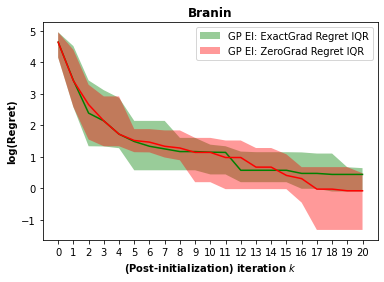

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_exact, color = 'Green')
plt.plot(median_zero, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Green', alpha=0.4, label='GP EI: ExactGrad Regret IQR')
plt.fill_between(xstar, lower_zero, upper_zero, facecolor = 'Red', alpha=0.4, label='GP EI: ZeroGrad Regret IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_exact, time_zero


(3281.113990545273, 180.1151638031006)

In [100]:
np.round(zero_1.acqfunc(x_test)[0],2).reshape(50,10)


array([[-1.83, -1.68, -1.52, -1.35, -1.18, -1.02, -0.85, -0.69, -0.54,
        -0.41],
       [-0.3 , -0.2 , -0.13, -0.08, -0.04, -0.02, -0.01, -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.01, -0.02,
        -0.02],
       [-0.04, -0.05, -0.07, -0.1 , -0.12, 

In [101]:
np.round(exact_1.acqfunc(x_test)[0],2).reshape(50,10)


array([[-1.13, -1.01, -0.89, -0.77, -0.65, -0.54, -0.43, -0.33, -0.25,
        -0.18],
       [-0.12, -0.07, -0.04, -0.02, -0.01, -0.01, -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
        -0.01],
       [-0.01, -0.02, -0.02, -0.03, -0.04, 

In [102]:
np.mean(exact_1.acqfunc(x_test)[0]), np.mean(zero_1.acqfunc(x_test)[0])


(-0.2512536326957021, -0.3185789275749701)

In [103]:
exact_1.acqfunc(x_test)[1].shape, zero_1.acqfunc(x_test)[1].shape


((500, 2), (500, 2))

In [104]:
np.round(exact_1.acqfunc(x_test)[1],2)


array([[-1.4 , -1.4 ],
       [-1.44, -1.44],
       [-1.46, -1.46],
       [-1.45, -1.45],
       [-1.42, -1.42],
       [-1.35, -1.35],
       [-1.25, -1.25],
       [-1.12, -1.12],
       [-0.97, -0.97],
       [-0.79, -0.79],
       [-0.62, -0.62],
       [-0.45, -0.45],
       [-0.31, -0.31],
       [-0.19, -0.19],
       [-0.11, -0.11],
       [-0.05, -0.05],
       [-0.02, -0.02],
       [-0.01, -0.01],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.  , -0.  ],
       [-0.

In [105]:
np.mean(exact_1.acqfunc(x_test)[1])


-0.37228711338926307